# Quad scan 'simulation'

In [1]:
import numpy as np
from numpy import sin, cos, sinh, cosh, sqrt
import matplotlib.pyplot as plt

%pylab --no-import-all inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


# Linear models 

In [2]:
def thin_quad_mat2(kL):
    return np.array( [ [1, 0], [-kL, 1] ])

def drift_mat2(L):
    return np.array( [ [1, L], [0, 1] ])

def quad_mat2(kL, L=0):
    """
    Quadrupole transfer matrix, 2x2. Note that 
    
    """
    
    if L == 0:
        return thin_quad_mat2(kL)
    
    k = kL/L
    
    if k == 0:
        mat2 = drift_mat2(L)
    elif k > 0:
        # Focusing
        rk = sqrt(k)
        phi = rk*L
        mat2 =  [ [cos(phi), sin(phi)/rk], [-rk*sin(phi), cos(phi)] ]
    else:
        # Defocusing
        rk = sqrt(-k)
        phi = rk*L
        mat2 = [ [cosh(phi), sinh(phi)/rk], [rk*sinh(phi), cosh(phi)] ]
        
    return mat2


def quad_drift_mat2(kL, *, Ltot=2.0,  Lquad=0):
    """
    Composite [quad, drift] 2x2 transfer matrix. 
    """
    
    Ldrift = Ltot - Lquad
    
    return drift_mat2(Ldrift) @ quad_mat2(kL, Lquad)

quad_drift_mat2(0), quad_drift_mat2(0, Lquad=0.1)

(array([[1., 2.],
        [0., 1.]]),
 array([[1., 2.],
        [0., 1.]]))

In [3]:
# Check symplecticity
np.linalg.det(quad_drift_mat2(1.234, Lquad=0.1))

0.9999999999999999

# Sigma mat

In [4]:
def propagate_sigma(sigma_mat2, mat2):
    return (mat2 @ sigma_mat2) @ mat2.T

In [5]:
def emit_calc(sigma_mat2):
    return np.sqrt(np.linalg.det(sigma_mat2))

In [6]:
# Some beam covariance matrix

EMIT = 1e-9
BETA_X = 10
ALPHA_X = -1
GAMMA_X = (1+ALPHA_X**2)/BETA_X
SIGMA_X = sqrt(EMIT*BETA_X)
SIGMA_PX = sqrt(EMIT*GAMMA_X)
COV_X__PX = -ALPHA_X*EMIT


SIGMA_11 = SIGMA_X**2
SIGMA_12 = COV_X__PX
SIGMA_22 = SIGMA_PX**2

SIGMA0 = np.array([[SIGMA_11, SIGMA_12], [SIGMA_12, SIGMA_22]])

# Check
emit_calc(SIGMA0)

1.0000000000000007e-09

In [7]:
SIGMA0

array([[1.e-08, 1.e-09],
       [1.e-09, 2.e-10]])

In [8]:
propagate_sigma(SIGMA0, quad_drift_mat2(1*0.108, Lquad=0.108, Ltot=2.26))

array([[1.02454094e-08, 1.40781785e-10],
       [1.40781785e-10, 9.95391663e-11]])

# Beam size measuement via quad scan

Demonstrates the effects of different models that produce the data.

In [9]:
#@np.vectorize
def beam_size_meas(kL, sigma0, Ltot=2.2, Lquad=0):
    
    mat2 = quad_drift_mat2(kL, Lquad=Lquad, Ltot=Ltot)

    sigma1 = propagate_sigma(sigma0, mat2)
    
    return np.sqrt(sigma1[0,0])

    
beam_size_meas(0, SIGMA0)    

0.00012396773773849388

In [10]:
@np.vectorize
def model1(kL):
    return beam_size_meas(kL, SIGMA0, Ltot=2.26, Lquad=0)

@np.vectorize
def model2(kL):
    return beam_size_meas(kL, SIGMA0, Ltot=2.26, Lquad=0.108)

@np.vectorize
def model3(kL):
    return beam_size_meas(kL, SIGMA0, Ltot=2.26*1.1, Lquad=0.108)

kLlist = np.linspace(0.2, 0.7, 10)

# Make the data
meas1 =  np.array([model1(k) for k in kLlist])
meas2 =  np.array([model2(k) for k in kLlist])
meas3 =  np.array([model3(k) for k in kLlist])




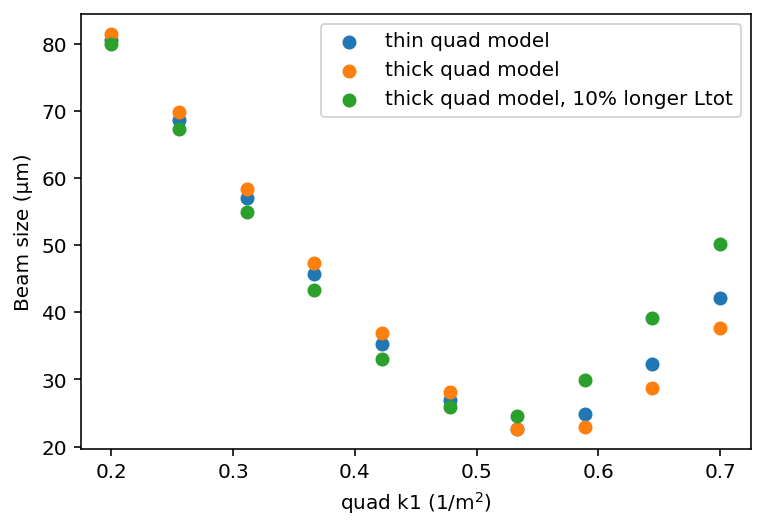

In [11]:
plt.scatter(kLlist, meas1*1e6, label='thin quad model')
plt.scatter(kLlist, meas2*1e6, label='thick quad model')
plt.scatter(kLlist, meas3*1e6, label='thick quad model, 10% longer Ltot')
#plt.scatter(klist, meas3*1e6, label='thick quad model, 10% higher Lquad')
plt.xlabel(r'quad k1 (1/m$^2$)')
plt.ylabel('Beam size (µm)')
plt.legend()

# Simple thin quad Reconstruction

In [12]:
import numpy.polynomial.polynomial as poly

def estimate_sigma_mat_thin_quad_drift(sizes, kLlist, d=2.26, plot=True):
    """
    Estimates the beam sigma matrix at a screen by scanning an upstream quad.
    This models the system as a thin quad.
    
    Parameters
    ----------
    sizes : array of float
        measured beam sizes at the screen
        
    kLlist : array of float
        kL of the upstream
        
    d : float
        distance from thin quad to the screen. 
    
    Returns
    -------
    
    sig_11_screen : array of float
    
    sig_12_screen : array of float
    
    sig_22_screen : tuple of float
    
    """

    
    coefs = poly.polyfit(kLlist, sizes**2, 2)

    c0, c1, c2 = coefs[0:3]
    
    # These are the inferred beam sigma matrix elements in front of quad
    sig_11 = c2 / d**2
    sig_12 = (-c1 - 2*d*sig_11) / (2*d**2)
    sig_22 = (c0 - sig_11 - 2*d*sig_12) / d**2
    emit2 = sig_11*sig_22 - sig_12**2
    
    # Matrix form
    sigma0 = np.array([ [sig_11, sig_12], [sig_12, sig_22] ])
    
    
    # emittance^2 directly
    emit2 = (4*c0*c2 - c1**2) / (4 * d**4)
    emit = np.sqrt(emit2)
    
    # Propagate forward to the screen
    sig_11_screen = []
    sig_12_screen = []
    sig_22_screen = []
    
    for kL in kLlist:
        mat2 = quad_drift_mat2(kL, Lquad=0, Ltot=d)
        sigma1 = propagate_sigma(sigma0, mat2)
        sig_11_screen.append(sigma1[0,0])
        sig_12_screen.append(sigma1[0,1])        
        sig_22_screen.append(sigma1[1,1])        

    sig_11_screen = np.array(sig_11_screen)
    sig_12_screen = np.array(sig_12_screen)
    sig_22_screen = np.array(sig_22_screen)
        
    if plot:
        # Plot the data
        plt.scatter(kLlist, sizes**2, marker='x', label=f'emit: {emit*1e9:0.2f} nm')
        
        # Sanity check
        #plt.scatter(kLlist, sig_11_screen, marker='.', label=f'inferred emit: {emit*1e9:0.2f} nm')
        
        # plot the fit
        xfit = np.linspace(np.min(kLlist), np.max(kLlist), 100)
        plt.plot(xfit, poly.polyval(xfit, coefs))
        
        plt.xlabel('kL (1/m)')
        plt.ylabel(f'sizes^2 (m$^2$)')    
    
    return sig_11_screen, sig_12_screen, sig_22_screen

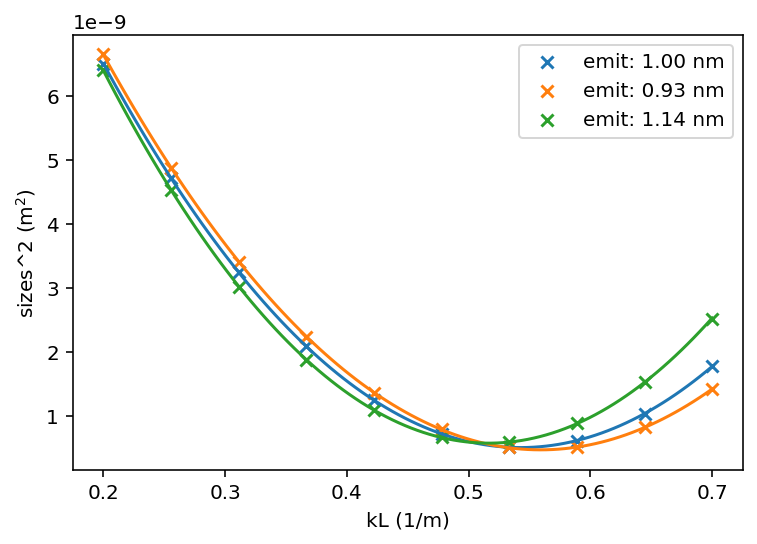

In [13]:
estimate_sigma_mat_thin_quad_drift(meas1, kLlist)
estimate_sigma_mat_thin_quad_drift(meas2, kLlist)
estimate_sigma_mat_thin_quad_drift(meas3, kLlist)
plt.legend()

# Pseudoinverse Method

This is better method, described in https://s3.cern.ch/inspire-prod-files-f/ffc80fb819125943207d0a1b2e71c32e


In [14]:
import scipy.linalg

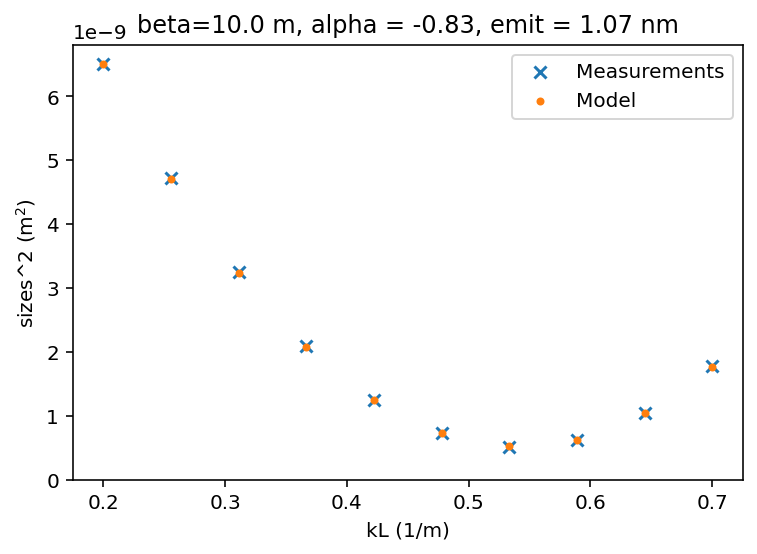

In [15]:
def estimate_sigma_mat_thick_quad_drift(sizes, kLlist, weights=None, Ltot=2.26, Lquad=0.108, plot=True):
    """
    Estimates the beam sigma matrix at a screen by scanning an upstream quad.

    This models the system as a thick quad.
    
    Parameters
    ----------
    sizes : array of float
        measured beam sizes at the screen
        
    kLlist : array of float
        kL of the upstream
        
        
    weights : array of float or None
        If present, each measurement will be weighted by this factor.
        
    Ltot : float
        total length in meters
    
    Lquad: float
        Length of the quadrupole magnet in meters
        
    plot : bool
    
    Returns
    -------
    
    s11_screen : array of float
    
    s12_screen : array of float
    
    s22_screen : tuple of float
    
    """    

    # measuerement vector
    b = sizes**2
    n = len(b)
    
    # Fill in defaults, checking. 
    if weights is None:
        weights = np.ones(n)
    assert len(weights) == n
    
    # Multiply by weights. This should corresond to the other weight multiplication below
    b = weights * sizes**2
    
    # form B matrix
    B = []
    # Collect mat2 for later
    mat2s = []
    for kL, weight in zip(kLlist, weights):
        mat2 = quad_drift_mat2(kL, Ltot=Ltot,  Lquad=Lquad)
        mat2s.append(mat2)
        r11, r12, r21, r22 = mat2.flatten()    
        B.append( np.array([ r11**2, 2*r11*r12, r12**2])*weight ) # correcponding weight multiplication
    B = np.array(B)    
    
    # Invert (pseudoinverse)
    s11, s12, s22 = scipy.linalg.pinv(B) @ b
    
    # Twiss calc just before the quad
    emit2 = s11*s22 - s12**2
    emit = np.sqrt(emit2)
    beta = s11/emit
    alpha = -s12/emit
    # gamma = s22/emit
    
    # Matrix form for propagation
    sigma0 = np.array([ [s11, s12], [s12, s22] ])
         
    # Propagate forward to the screen
    s11_screen = []
    s12_screen = []
    s22_screen = []
    for kL, mat2 in zip(kLlist, mat2s):
        sigma1 = propagate_sigma(sigma0, mat2)
        s11_screen.append(sigma1[0,0])
        s12_screen.append(sigma1[0,1])       
        s22_screen.append(sigma1[1,1])       
    s11_screen = np.array(s11_screen)
    s12_screen = np.array(s12_screen)
    s22_screen = np.array(s22_screen)

    if plot:
        # Plot the data
        plt.scatter(kLlist, sizes**2, marker='x', label=f'Measurements')
        
        # Model prediction
        plt.scatter(kLlist, s11_screen, marker='.', label=f'Model')
                
        plt.title(f'beta={beta:.1f} m, alpha = {alpha:0.2f}, emit = {emit*1e9:0.2f} nm')
        plt.xlabel('kL (1/m)')
        plt.ylabel(f'sizes^2 (m$^2$)')
        plt.ylim(0, None)
        plt.legend()
    
    return s11_screen, s12_screen, s22_screen

# Data from thin quad 'simulation'
estimate_sigma_mat_thick_quad_drift(meas1, kLlist);

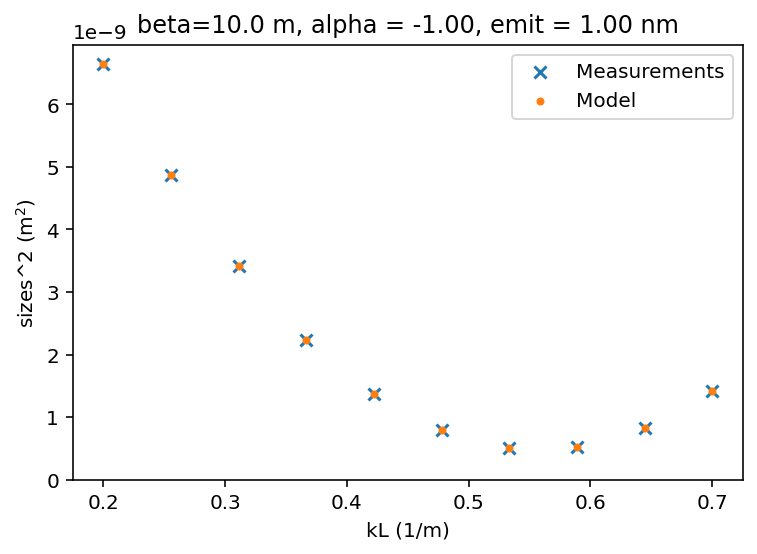

In [16]:
# Data from thick quad 'simulation' Note that this gets it exactly correct.
estimate_sigma_mat_thick_quad_drift(meas2, kLlist);

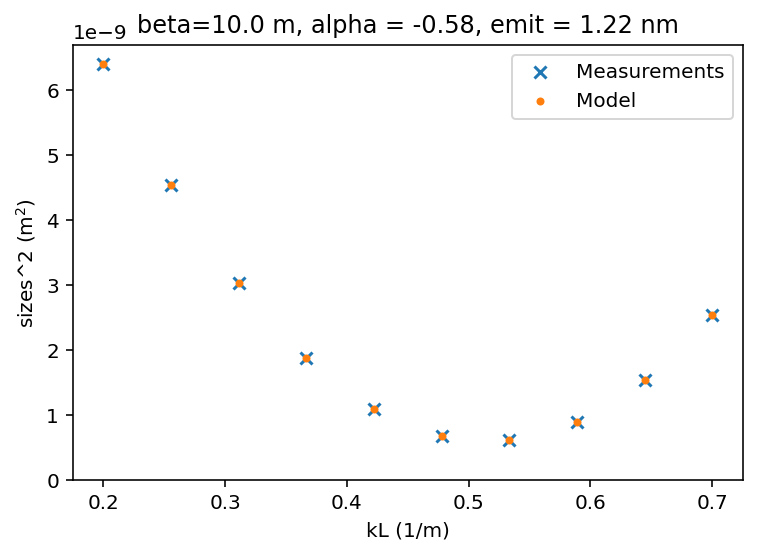

In [17]:
# Data from thick quad 'simulation' with 10% longer drift
estimate_sigma_mat_thick_quad_drift(meas3, kLlist);

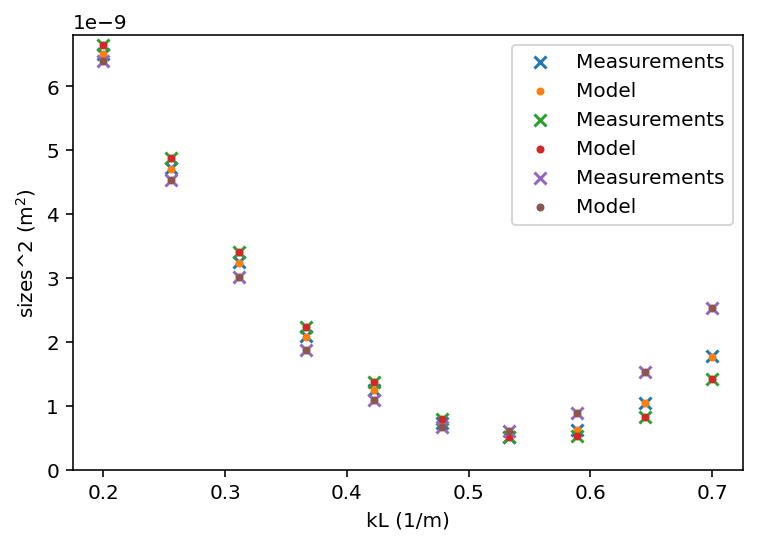

In [18]:
# All together
estimate_sigma_mat_thick_quad_drift(meas1, kLlist);
estimate_sigma_mat_thick_quad_drift(meas2, kLlist);
estimate_sigma_mat_thick_quad_drift(meas3, kLlist);
plt.title('');

# Bmag

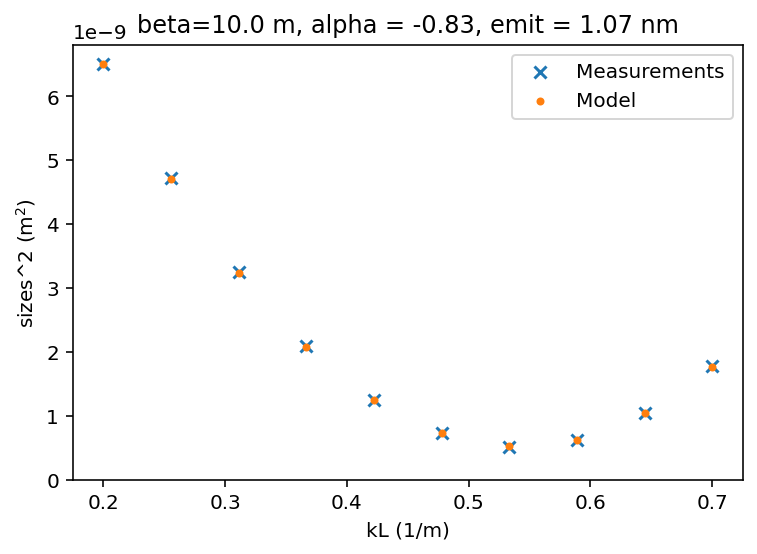

In [19]:
sig_11_screen, sig_12_screen, sig_22_screen = estimate_sigma_mat_thick_quad_drift(meas1, kLlist)

In [20]:
def twiss_and_bmag(sig_11, sig_12, sig_22, beta0=1, alpha0=0):
    """
    Calculates Twiss ang Bmag from the sigma matrix.
    
    Note that px here is x'
    """
    emit  = np.sqrt(sig_11 * sig_22 - sig_12**2) 
    beta  = sig_11/emit
    alpha = -sig_12/emit
    gamma = sig_22/emit
    
    # Form bmag
    gamma0 = (1+alpha0**2)/beta0
    bmag = (beta * gamma0 - 2*alpha * alpha0 + gamma * beta0) / 2
    
    d = {}
    d['emit'] = emit
    d['beta'] = beta
    d['alpha'] = alpha
    d['bmag'] = bmag
    
    return d

In [21]:
res = twiss_and_bmag(sig_11_screen, sig_12_screen, sig_22_screen)

(0.0, 3.255609435955326)

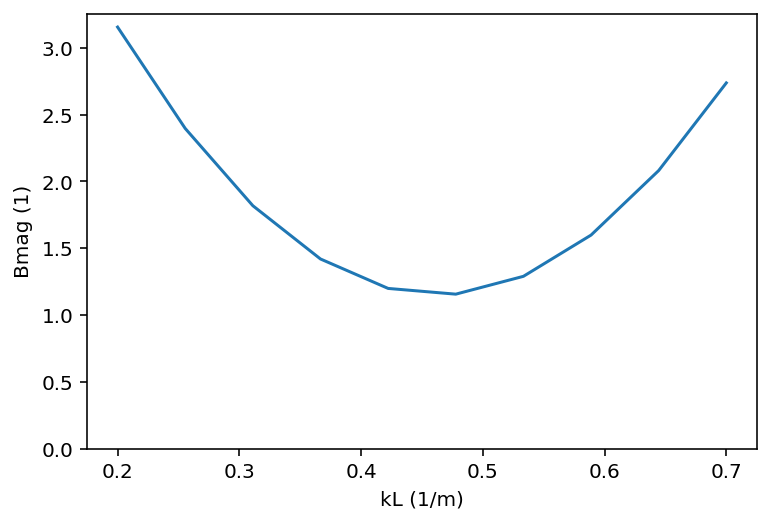

In [22]:
fig, ax = plt.subplots()

ax.plot(kLlist, res['bmag'])
ax.set_xlabel('kL (1/m)')
ax.set_ylabel('Bmag (1)')
ax.set_ylim(0, None)

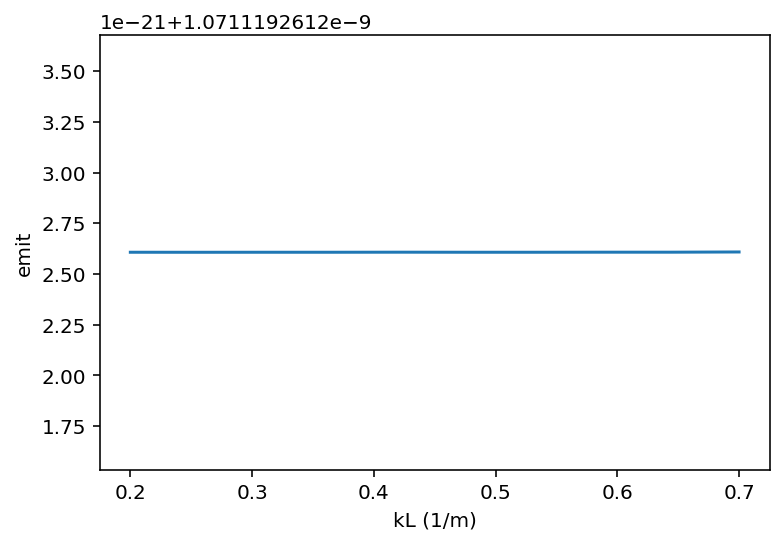

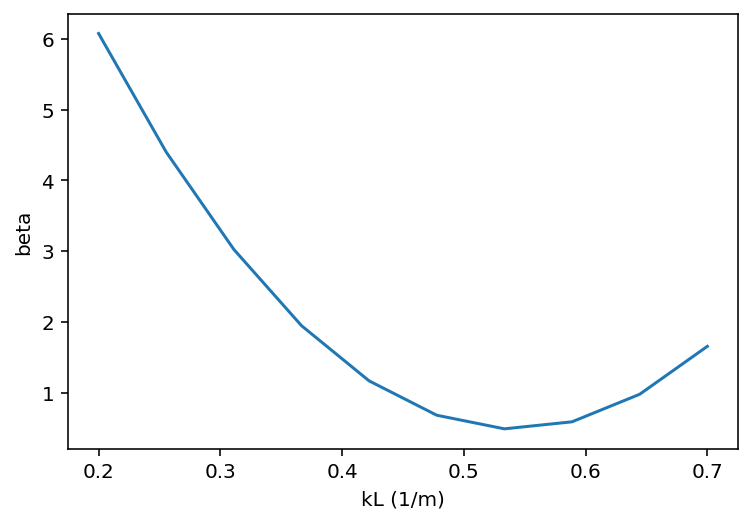

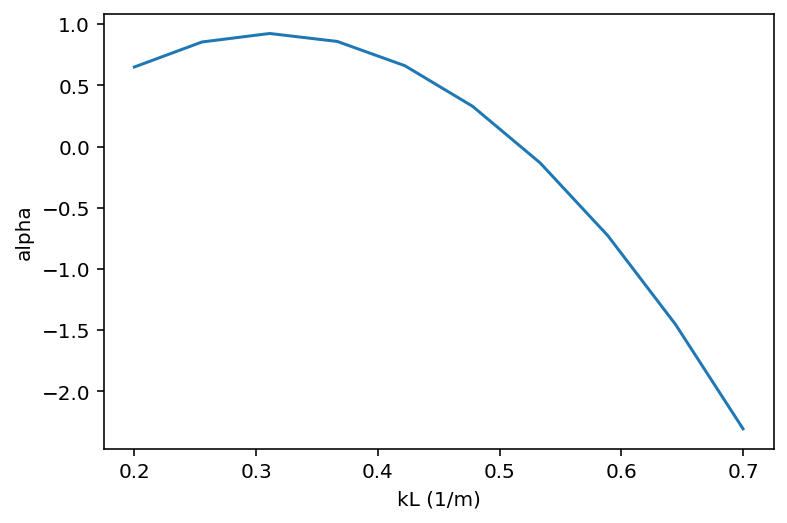

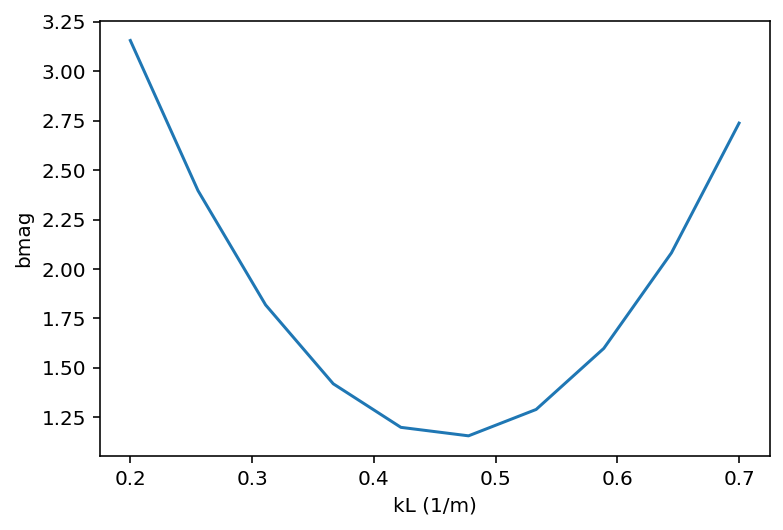

In [23]:
# All plots
for k in res:
    fig, ax = plt.subplots()
    
    ax.plot(kLlist, res[k])
    ax.set_xlabel('kL (1/m)')
    ax.set_ylabel(k)
    
    